# Image classification of cardiomyocyte tissues

This pipeline classifies cardiomyocyte images to distinguish issues from patients with chronic heart failure from ones from health donnors. It builds an image classifier using a `tf.keras.Sequential` model and load data using `tf.keras.preprocessing.image.ImageDataGenerator`. The images downloaded from https://idr.openmicroscopy.org/webclient/?show=project-402 processed with the following:

* Building _data input pipelines_ using the `tf.keras.preprocessing.image.ImageDataGenerator` class to efficiently work with data on disk to use with the model.
* _Overfitting_ —How to identify and prevent it.
* _Data augmentation_ and _dropout_ —Key techniques to fight overfitting in computer vision tasks to incorporate into the data pipeline and image classifier model.

This pipeline follows a basic machine learning workflow:

1. Examine and understand data
2. Build an input pipeline
3. Build the model
4. Train the model
5. Test the model
6. Improve the model and repeat the process

## Import packages

It is always a good idea to import packages separately to minimise their impact on compatibility.

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

Import Tensorflow and the Keras classes needed to construct our model.

In [2]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

## Load data

Download the dataset idr0042 with the OMERO 5.6.1 JSON API https://docs.openmicroscopy.org/omero/5.6.1/developers/json-api.html. The dataset is stored in the "/tmp/" directory for training and verification.

In [4]:
################################
# Create a session to access IDR
################################
import requests


def get_session() -> requests.Session:
    IDR_BASE_URL = "https://idr.openmicroscopy.org"
    INDEX_PAGE = "%s/webclient/?experimenter=-1" % IDR_BASE_URL

    # create http session
    with requests.Session() as session:
        request = requests.Request('GET', INDEX_PAGE)
        prepped = session.prepare_request(request)
        response = session.send(prepped)
        if response.status_code != 200:
            response.raise_for_status()
    return session

In [5]:
######################
# Access test data set
######################
# import json
# from IPython.display import display, HTML
import os
import tensorflow as tf

OUTPUT_PATH = '/tmp'


def download_img(ds_id: str, session: requests.Session, output_path: str = OUTPUT_PATH):
    IDR_BASE_URL = "https://idr.openmicroscopy.org"
    DS_IMG_URI = "{base}/api/v0/m/datasets/{dataset_id}/images/?limit=2500"         # test 1155, training 1144
    IMG_RDR_URI = "{base}/webgateway/render_image/{image_id}/0/0/"
    IMG_ANNO_URI = "{base}/webclient/api/annotations/?type=map&{type}={image_id}"

    qs_ds = {'base': IDR_BASE_URL, 'dataset_id': ds_id}
    r = session.get(DS_IMG_URI.format(**qs_ds))
    # print('HTTP status for image:', r.status_code)
    if r.status_code == 200:
        #     print (json.dumps(r.json()['data'][:1], indent=2, sort_keys=True))
        for img in r.json()['data']:    # [:2]:
            img_name = img['Name']
            img_id = img['@id']
            img_path = ''

            qs_img = {'base': IDR_BASE_URL, 'image_id': img_id}
            # display(HTML("<img src='%s' />" % IMG_RDR_URI.format(**qs_img)))

            qs_anno = {'base': IDR_BASE_URL, 'type': 'image', 'image_id': img_id}
            r_anno = session.get(IMG_ANNO_URI.format(**qs_anno))
            # print('HTTP status for annotation:', r_anno.status_code)
            for a in r_anno.json()['annotations']:
                for v in a['values']:
                    key = v[0]
                    value = v[1]
                    print(key, ':', value)

                    if key == 'Diagnosis' and value != 'heart tissue pathology':
                        path = os.path.join(output_path, value.replace(" ", "_"))
                        if not os.path.exists(path):
                            os.system("mkdir -p " + path)
                        img_path = tf.keras.utils.get_file(fname=os.path.join(path, img_name), origin=IMG_RDR_URI.format(**qs_img))
            print(img_name, img_id, img_path)
            print('')       # pretty print
    return output_path


# dataset IDs
DS_TEST_ID = "827"
DS_TRAIN_ID = "828"

validation_dir: str = download_img(ds_id=DS_TEST_ID, session=get_session(), output_path=os.path.join(OUTPUT_PATH, 'validation'))
train_dir: str = download_img(ds_id=DS_TRAIN_ID, session=get_session(), output_path=os.path.join(OUTPUT_PATH, 'train'))

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 47 years
Individual : 33375
Clinical History : non-ischemic cardiomyopathy
33375_0_fal_1_0.png 3428066 /tmp/validation/chronic_heart_failure/33375_0_fal_1_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 47 years
Individual : 33375
Clinical History : non-ischemic cardiomyopathy
33375_0_fal_20_0.png 3428067 /tmp/validation/chronic_heart_failure/33375_0_fal_20_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 47 years
Individual : 33375
Clinical History : non-ischemic cardiomyopathy
33375_0_fal_23_0.png 3428068 /tmp/validation/chronic_heart_

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 60 years
Individual : 33388
Clinical History : ischemic cardiomyopathy
33388_0_fal_13_0.png 3428089 /tmp/validation/chronic_heart_failure/33388_0_fal_13_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 60 years
Individual : 33388
Clinical History : ischemic cardiomyopathy
33388_0_fal_14_0.png 3428090 /tmp/validation/chronic_heart_failure/33388_0_fal_14_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 60 years
Individual : 33388
Clinical History : ischemic cardiomyopathy
33388_0_fal_15_0.png 3428091 /tmp/validati

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : African American
Age : 62 years
Individual : 33394
Clinical History : ischemic cardiomyopathy
33394_0_fal_38_0.png 3428116 /tmp/validation/chronic_heart_failure/33394_0_fal_38_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : African American
Age : 62 years
Individual : 33394
Clinical History : ischemic cardiomyopathy
33394_0_fal_40_0.png 3428117 /tmp/validation/chronic_heart_failure/33394_0_fal_40_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : African American
Age : 62 years
Individual : 33394
Clinical History : ischemic cardiomyopathy
33394_0_fal_47_0.png 

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : African American
Age : 64 years
Individual : 33400
Clinical History : ischemic cardiomyopathy
33400_0_fal_29_0.png 3428140 /tmp/validation/chronic_heart_failure/33400_0_fal_29_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : African American
Age : 64 years
Individual : 33400
Clinical History : ischemic cardiomyopathy
33400_0_fal_30_0.png 3428142 /tmp/validation/chronic_heart_failure/33400_0_fal_30_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 52 years
Individual : 33401
Clinical History : ischemic cardiomyopathy
33401_0_fal_1_0.png 3428145 

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 58 years
Individual : 33406
Clinical History : ischemic cardiomyopathy
33406_0_fal_1_0.png 3428166 /tmp/validation/chronic_heart_failure/33406_0_fal_1_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 58 years
Individual : 33406
Clinical History : ischemic cardiomyopathy
33406_0_fal_17_0.png 3428165 /tmp/validation/chronic_heart_failure/33406_0_fal_17_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 58 years
Individual : 33406
Clinical History : ischemic cardiomyopathy
33406_0_fal_2_0.png 3428169 /tmp/validation/

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 48 years
Individual : 33408
Clinical History : non-ischemic cardiomyopathy
33408_0_fal_12_0.png 3428188 /tmp/validation/chronic_heart_failure/33408_0_fal_12_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 48 years
Individual : 33408
Clinical History : non-ischemic cardiomyopathy
33408_0_fal_15_0.png 3428189 /tmp/validation/chronic_heart_failure/33408_0_fal_15_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 48 years
Individual : 33408
Clinical History : non-ischemic cardiomyopathy
33408_0_fal_17_0.png 3428190 /tmp/validation/chronic_hear

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : African American
Age : 60 years
Individual : 33414
Clinical History : ischemic cardiomyopathy
33414_0_fal_29_0.png 3428213 /tmp/validation/chronic_heart_failure/33414_0_fal_29_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : African American
Age : 60 years
Individual : 33414
Clinical History : ischemic cardiomyopathy
33414_0_fal_3_0.png 3428217 /tmp/validation/chronic_heart_failure/33414_0_fal_3_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : African American
Age : 60 years
Individual : 33414
Clinical History : ischemic cardiomyopathy
33414_0_fal_34_0.png 34

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 58 years
Individual : 33417
Clinical History : non-ischemic cardiomyopathy
33417_0_fal_44_0.png 3428237 /tmp/validation/chronic_heart_failure/33417_0_fal_44_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 58 years
Individual : 33417
Clinical History : non-ischemic cardiomyopathy
33417_0_fal_48_0.png 3428238 /tmp/validation/chronic_heart_failure/33417_0_fal_48_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 58 years
Individual : 33417
Clinical History : non-ischemic cardiomyopathy
33417_0_fal_50_0.p

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 71 years
Individual : 33423
Clinical History : non-ischemic cardiomyopathy
33423_0_fal_17_0.png 3428260 /tmp/validation/chronic_heart_failure/33423_0_fal_17_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 71 years
Individual : 33423
Clinical History : non-ischemic cardiomyopathy
33423_0_fal_18_0.png 3428261 /tmp/validation/chronic_heart_failure/33423_0_fal_18_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 71 years
Individual : 33423
Clinical History : non-ischemic cardiomyopathy
33423_0_fal_19_0.png 3428262 /tmp/validation/chronic_hear

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 60 years
Individual : 33466
Clinical History : ischemic cardiomyopathy
33466_0_fal_7_0.png 3428285 /tmp/validation/chronic_heart_failure/33466_0_fal_7_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 66 years
Individual : 33467
Clinical History : non-ischemic cardiomyopathy
33467_0_fal_1_0.png 3428287 /tmp/validation/chronic_heart_failure/33467_0_fal_1_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 66 years
Individual : 33467
Clinical History : non-ischemic cardiomyopathy
33467_0_fal_11_0.png 3428286 /tmp/validation/chronic_hea

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 57 years
Individual : 33472
Clinical History : non-ischemic cardiomyopathy
33472_0_fal_11_0.png 3428309 /tmp/validation/chronic_heart_failure/33472_0_fal_11_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 57 years
Individual : 33472
Clinical History : non-ischemic cardiomyopathy
33472_0_fal_12_0.png 3428310 /tmp/validation/chronic_heart_failure/33472_0_fal_12_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 57 years
Individual : 33472
Clinical History : non-ischemic cardiomyopathy
33472_0_fal_13_0.png 3428311 /tmp/validation/chronic_hear

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 28 years
Individual : 33477
Clinical History : non-ischemic cardiomyopathy
33477_0_fal_8_0.png 3428339 /tmp/validation/chronic_heart_failure/33477_0_fal_8_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 28 years
Individual : 33477
Clinical History : non-ischemic cardiomyopathy
33477_0_fal_9_0.png 3428340 /tmp/validation/chronic_heart_failure/33477_0_fal_9_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 65 years
Individual : 33480
Clinical History : ischemic cardiomyopathy
33480_0_fal_10_0.png 3428341 /tmp/validation/chronic_hea

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 64 years
Individual : 33484
Clinical History : ischemic cardiomyopathy
33484_0_fal_20_0.png 3428365 /tmp/validation/chronic_heart_failure/33484_0_fal_20_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 64 years
Individual : 33484
Clinical History : ischemic cardiomyopathy
33484_0_fal_25_0.png 3428366 /tmp/validation/chronic_heart_failure/33484_0_fal_25_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 64 years
Individual : 33484
Clinical History : ischemic cardiomyopathy
33484_0_fal_28_0.png 3428367 /tmp/validati

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : African American
Age : 62 years
Individual : 33537
Clinical History : ischemic cardiomyopathy
33537_0_fal_25_0.png 3428391 /tmp/validation/chronic_heart_failure/33537_0_fal_25_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : African American
Age : 62 years
Individual : 33537
Clinical History : ischemic cardiomyopathy
33537_0_fal_26_0.png 3428392 /tmp/validation/chronic_heart_failure/33537_0_fal_26_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : African American
Age : 62 years
Individual : 33537
Clinical History : ischemic cardiomyopathy
33537_0_fal_27_0.png 

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 68 years
Individual : 33539
Clinical History : ischemic cardiomyopathy
33539_0_fal_35_0.png 3428414 /tmp/validation/chronic_heart_failure/33539_0_fal_35_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 68 years
Individual : 33539
Clinical History : ischemic cardiomyopathy
33539_0_fal_44_0.png 3428415 /tmp/validation/chronic_heart_failure/33539_0_fal_44_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 68 years
Individual : 33539
Clinical History : ischemic cardiomyopathy
33539_0_fal_50_0.png 3428416 /tmp/validati

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 64 years
Individual : 33546
Clinical History : non-ischemic cardiomyopathy
33546_0_fal_19_0.png 3428440 /tmp/validation/chronic_heart_failure/33546_0_fal_19_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 64 years
Individual : 33546
Clinical History : non-ischemic cardiomyopathy
33546_0_fal_22_0.png 3428441 /tmp/validation/chronic_heart_failure/33546_0_fal_22_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 64 years
Individual : 33546
Clinical History : non-ischemic cardiomyopathy
33546_0_fal_23_0.p

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Individual : 33549
Clinical History : non-ischemic cardiomyopathy
33549_0_fal_19_0.png 3428463 /tmp/validation/chronic_heart_failure/33549_0_fal_19_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Individual : 33549
Clinical History : non-ischemic cardiomyopathy
33549_0_fal_24_0.png 3428465 /tmp/validation/chronic_heart_failure/33549_0_fal_24_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Individual : 33549
Clinical History : non-ischemic cardiomyopathy
33549_0_fal_26_0.png 3428466 /tmp/validation/chronic_heart_failure/33549_0_fal_26_0.png

Organism : Ho

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 59 years
Individual : 34072
Clinical History : normal cardiovascular function by cardiac catheterization
34072_1_nrm_2_0.png 3428494 /tmp/validation/not_chronic_heart_failure/34072_1_nrm_2_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 59 years
Individual : 34072
Clinical History : normal cardiovascular function by cardiac catheterization
34072_1_nrm_21_0.png 3428489 /tmp/validation/not_chronic_heart_failure/34072_1_nrm_21_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 59 years
Individual : 34072
Clinical History : normal cardiovascular function by cardiac catheterization
34072_1_nrm_23_0.png 3428490 /tmp/validation/not

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 57 years
Individual : 34074
Clinical History : non-ischemic cardiomyopathy
34074_0_fal_34_0.png 3428511 /tmp/validation/chronic_heart_failure/34074_0_fal_34_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 57 years
Individual : 34074
Clinical History : non-ischemic cardiomyopathy
34074_0_fal_48_0.png 3428512 /tmp/validation/chronic_heart_failure/34074_0_fal_48_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 57 years
Individual : 34074
Clinical History : non-ischemic cardiomyopathy
34074_0_fal_49_0.png 3428513 /tmp/validation/chronic_hear

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 51 years
Individual : 34077
Clinical History : non-ischemic cardiomyopathy
34077_0_fal_41_0.png 3428534 /tmp/validation/chronic_heart_failure/34077_0_fal_41_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 51 years
Individual : 34077
Clinical History : non-ischemic cardiomyopathy
34077_0_fal_43_0.png 3428535 /tmp/validation/chronic_heart_failure/34077_0_fal_43_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 51 years
Individual : 34077
Clinical History : non-ischemic cardiomyopathy
34077_0_fal_6_0.png 3428537 /tmp/validation/chronic_heart

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 61 years
Individual : 34085
Clinical History : non-ischemic cardiomyopathy
34085_0_fal_47_0.png 3428559 /tmp/validation/chronic_heart_failure/34085_0_fal_47_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 61 years
Individual : 34085
Clinical History : non-ischemic cardiomyopathy
34085_0_fal_48_0.png 3428560 /tmp/validation/chronic_heart_failure/34085_0_fal_48_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 54 years
Individual : 34086
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function


Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : heart tissue pathology
Disease Subtype : myocardium disease
Sex : male
Ethnic or Racial Group : Caucasian
Age : 24 years
Individual : 34088
Clinical History : donor without a history of chronic symptomatic heart failure but tissue pathology
34088_1_nrm_25_0.png 3428582 

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : female
Ethnic or Racial Group : Caucasian
Age : 48 years
Individual : 34089
Clinical History : non-ischemic cardiomyopathy
34089_0_fal_10_0.png 3428583 /tmp/validation/chronic_heart_failure/34089_0_fal_10_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : female
Ethnic or Racial Group : Caucasian
Age : 48 years
Individual : 34089
Clinical History : non-ischemic cardiomyopathy
34089_0_fal_11_0.png 3428584 /tmp/validation/chronic

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : heart tissue pathology
Disease Subtype : myocardium disease
Sex : male
Ethnic or Racial Group : Caucasian
Age : 59 years
Individual : 34092
Clinical History : donor without a history of chronic symptomatic heart failure but tissue pathology
34092_1_nrm_18_0.png 3428606 

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : heart tissue pathology
Disease Subtype : myocardium disease
Sex : male
Ethnic or Racial Group : Caucasian
Age : 59 years
Individual : 34092
Clinical History : donor without a history of chronic symptomatic heart failure but tissue pathology
34092_1_nrm_20_0.png 3428607 

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : heart tissue pathology
Disease Subtype : myocardium disease
Sex : male
Ethnic or Racial Group : Caucasian
Age : 59 years
Individual : 34092
Clinical History : donor without a history of chronic symptomatic heart failure but tissue pathol

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : female
Ethnic or Racial Group : Caucasian
Age : 53 years
Individual : 34238
Clinical History : non-ischemic cardiomyopathy
34238_0_fal_12_0.png 3428629 /tmp/validation/chronic_heart_failure/34238_0_fal_12_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : female
Ethnic or Racial Group : Caucasian
Age : 53 years
Individual : 34238
Clinical History : non-ischemic cardiomyopathy
34238_0_fal_13_0.png 3428630 /tmp/validation/chronic_heart_failure/34238_0_fal_13_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : female
Ethnic or Racial Group : Caucasian
Age : 53 years
Individual : 34238
Clinical History : non-ischemic cardiomyopathy
34238_0_fal_14_0.png 3428631 /tmp/validation/chroni

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 59 years
Individual : 34296
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
34296_1_nrm_7_0.png 3428659 /tmp/validation/not_chronic_heart_failure/34296_1_nrm_7_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : African American
Age : 44 years
Individual : 35589
Clinical History : normal cardiovascular function by cardiac catheterization
35589_1_nrm_10_0.png 3428660 /tmp/validation/not_chronic_heart_failure/35589_1_nrm_10_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : African American
Age : 44 years
Individual : 35589
Clinical History : normal cardiovascular function by ca

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 71 years
Individual : 35590
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35590_1_nrm_45_0.png 3428680 /tmp/validation/not_chronic_heart_failure/35590_1_nrm_45_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Hispanic
Age : 69 years
Individual : 35592
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35592_1_nrm_11_0.png 3428682 /tmp/validation/not_chronic_heart_failure/35592_1_nrm_11_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Hispanic
Age : 69 years
Individual : 35592
Clinical Hist

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 52 years
Individual : 35594
Clinical History : normal cardiovascular function by cardiac catheterization
35594_1_nrm_8_0.png 3428703 /tmp/validation/not_chronic_heart_failure/35594_1_nrm_8_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : African American
Age : 73 years
Individual : 35597
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35597_1_nrm_10_0.png 3428704 /tmp/validation/not_chronic_heart_failure/35597_1_nrm_10_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : African American
Age : 73 years
Individual : 35597
Clinical History : donor without a history of chron

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 51 years
Individual : 35599
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35599_1_nrm_7_0.png 3428725 /tmp/validation/not_chronic_heart_failure/35599_1_nrm_7_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : African American
Age : 53 years
Individual : 35601
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35601_1_nrm_1_0.png 3428729 /tmp/validation/not_chronic_heart_failure/35601_1_nrm_1_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : African American
Age : 53 years
Individual : 35601
Cli

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 8 years
Individual : 35602
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35602_1_nrm_8_0.png 3428747 /tmp/validation/not_chronic_heart_failure/35602_1_nrm_8_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 65 years
Individual : 35603
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35603_1_nrm_10_0.png 3428748 /tmp/validation/not_chronic_heart_failure/35603_1_nrm_10_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 65 years
Individual : 35603
Clinical His

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 80 years
Individual : 35607
Clinical History : normal cardiovascular function by cardiac catheterization
35607_1_nrm_22_0.png 3428774 /tmp/validation/not_chronic_heart_failure/35607_1_nrm_22_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 80 years
Individual : 35607
Clinical History : normal cardiovascular function by cardiac catheterization
35607_1_nrm_27_0.png 3428775 /tmp/validation/not_chronic_heart_failure/35607_1_nrm_27_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 80 years
Individual : 35607
Clinical History : normal cardiovascular function by cardiac catheterization
35607_1_nrm_3_0.png 3428778 /tmp/validat

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : African American
Age : 3 years
Individual : 35625
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35625_1_nrm_17_0.png 3428805 /tmp/validation/not_chronic_heart_failure/35625_1_nrm_17_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : African American
Age : 3 years
Individual : 35625
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35625_1_nrm_2_0.png 3428808 /tmp/validation/not_chronic_heart_failure/35625_1_nrm_2_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : African American
Age : 3 years
Individual : 35625

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 43 years
Individual : 35628
Clinical History : normal cardiovascular function by cardiac catheterization
35628_1_nrm_2_0.png 3428828 /tmp/validation/not_chronic_heart_failure/35628_1_nrm_2_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 43 years
Individual : 35628
Clinical History : normal cardiovascular function by cardiac catheterization
35628_1_nrm_28_0.png 3428827 /tmp/validation/not_chronic_heart_failure/35628_1_nrm_28_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 43 years
Individual : 35628
Clinical History : normal cardiovascular function by cardiac catheterization
35628_1_nrm_30_0.png 3428829 /tmp/validation/not

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 56 years
Individual : 35630
Clinical History : normal cardiovascular function by cardiac catheterization
35630_1_nrm_4_0.png 3428857 /tmp/validation/not_chronic_heart_failure/35630_1_nrm_4_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 56 years
Individual : 35630
Clinical History : normal cardiovascular function by cardiac catheterization
35630_1_nrm_45_0.png 3428854 /tmp/validation/not_chronic_heart_failure/35630_1_nrm_45_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 56 years
Individual : 35630
Clinical History : normal cardiovascular function by cardiac catheterization
35630_1_nrm_47_0.png 3428855 /tmp/validation/not

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 48 years
Individual : 35635
Clinical History : normal cardiovascular function by cardiac catheterization
35635_1_nrm_5_0.png 3428878 /tmp/validation/not_chronic_heart_failure/35635_1_nrm_5_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 48 years
Individual : 35635
Clinical History : normal cardiovascular function by cardiac catheterization
35635_1_nrm_8_0.png 3428879 /tmp/validation/not_chronic_heart_failure/35635_1_nrm_8_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : African American
Age : 44 years
Individual : 35637
Clinical History : normal cardiovascular function by cardiac catheterization
35637_1_nrm_20_0.png 3428880 /tmp/validatio

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Hispanic
Age : 37 years
Individual : 35638
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35638_1_nrm_8_0.png 3428901 /tmp/validation/not_chronic_heart_failure/35638_1_nrm_8_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 59 years
Individual : 35643
Clinical History : normal cardiovascular function by cardiac catheterization
35643_1_nrm_13_0.png 3428902 /tmp/validation/not_chronic_heart_failure/35643_1_nrm_13_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 59 years
Individual : 35643
Clinical History : normal cardiovascular function by cardiac cathe

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 56 years
Individual : 35646
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35646_1_nrm_10_0.png 3428924 /tmp/validation/not_chronic_heart_failure/35646_1_nrm_10_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 56 years
Individual : 35646
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35646_1_nrm_1_0.png 3428928 /tmp/validation/not_chronic_heart_failure/35646_1_nrm_1_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 56 years
Individual : 35646
Clinical History 

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : African American
Age : 48 years
Individual : 35649
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35649_1_nrm_8_0.png 3428945 /tmp/validation/not_chronic_heart_failure/35649_1_nrm_8_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : African American
Age : 50 years
Individual : 35651
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35651_1_nrm_1_0.png 3428946 /tmp/validation/not_chronic_heart_failure/35651_1_nrm_1_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : African American
Age : 50 years
Individual : 

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 62 years
Individual : 35880
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35880_1_nrm_15_0.png 3428973 /tmp/validation/not_chronic_heart_failure/35880_1_nrm_15_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 62 years
Individual : 35880
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35880_1_nrm_16_0.png 3428974 /tmp/validation/not_chronic_heart_failure/35880_1_nrm_16_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 62 years
Individual : 35880
Clinical Histor

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 21 years
Individual : 36114
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
36114_1_nrm_8_0.png 3428999 /tmp/validation/not_chronic_heart_failure/36114_1_nrm_8_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 21 years
Individual : 36114
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
36114_1_nrm_9_0.png 3429000 /tmp/validation/not_chronic_heart_failure/36114_1_nrm_9_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 56 years
Individual : 36116
Clinical Hist

Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 78 years
Individual : 36121
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
36121_1_nrm_14_0.png 3429024 /tmp/validation/not_chronic_heart_failure/36121_1_nrm_14_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 78 years
Individual : 36121
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
36121_1_nrm_15_0.png 3429025 /tmp/validation/not_chronic_heart_failure/36121_1_nrm_15_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 78 years
Individual : 36121
Clinical History : donor without a history of chronic heart failure bu

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 53 years
Individual : 36129
Clinical History : normal cardiovascular function by cardiac catheterization
36129_1_nrm_10_0.png 3429045 /tmp/validation/not_chronic_heart_failure/36129_1_nrm_10_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 53 years
Individual : 36129
Clinical History : normal cardiovascular function by cardiac catheterization
36129_1_nrm_1_0.png 3429050 /tmp/validation/not_chronic_heart_failure/36129_1_nrm_1_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 53 years
Individual : 36129
Clinical History : normal cardiovascular function by cardiac catheterization
36129_1_nrm_11_0.png 3429046 /tmp/validation/not

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : African American
Age : 65 years
Individual : 33381
Clinical History : ischemic cardiomyopathy
33381_0_fal_16_0.png 3429597 /tmp/train/chronic_heart_failure/33381_0_fal_16_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : African American
Age : 65 years
Individual : 33381
Clinical History : ischemic cardiomyopathy
33381_0_fal_18_0.png 3429598 /tmp/train/chronic_heart_failure/33381_0_fal_18_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : African American
Age : 65 years
Individual : 33381
Clinical History : ischemic cardiomyopathy
33381_0_fal_25_0.png 3429599 /t

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 61 years
Individual : 33383
Clinical History : ischemic cardiomyopathy
33383_0_fal_22_0.png 3429621 /tmp/train/chronic_heart_failure/33383_0_fal_22_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 61 years
Individual : 33383
Clinical History : ischemic cardiomyopathy
33383_0_fal_3_0.png 3429622 /tmp/train/chronic_heart_failure/33383_0_fal_3_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 61 years
Individual : 33383
Clinical History : ischemic cardiomyopathy
33383_0_fal_42_0.png 3429623 /tmp/train/chronic_heart_

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 65 years
Individual : 33387
Clinical History : ischemic cardiomyopathy
33387_0_fal_24_0.png 3429633 /tmp/train/chronic_heart_failure/33387_0_fal_24_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 65 years
Individual : 33387
Clinical History : ischemic cardiomyopathy
33387_0_fal_3_0.png 3429638 /tmp/train/chronic_heart_failure/33387_0_fal_3_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 65 years
Individual : 33387
Clinical History : ischemic cardiomyopathy
33387_0_fal_31_

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : African American
Age : 63 years
Individual : 33393
Clinical History : non-ischemic cardiomyopathy
33393_0_fal_5_0.png 3429658 /tmp/train/chronic_heart_failure/33393_0_fal_5_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : African American
Age : 63 years
Individual : 33393
Clinical History : non-ischemic cardiomyopathy
33393_0_fal_7_0.png 3429659 /tmp/train/chronic_heart_failure/33393_0_fal_7_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : African American
Age : 63 years
Individual : 33393
Clinical History : non-ischemic cardiomyopathy
33393_0_fal_9_0.png 3429660 /tmp/train/chronic_hea

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 18 years
Individual : 33398
Clinical History : non-ischemic cardiomyopathy
33398_0_fal_9_0.png 3429242 /tmp/train/chronic_heart_failure/33398_0_fal_9_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 62 years
Individual : 33399
Clinical History : ischemic cardiomyopathy
33399_0_fal_1_0.png 3429245 /tmp/train/chronic_heart_failure/33399_0_fal_1_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 62 years
Individual : 33399
Clinical History : ischemic cardiomyopathy
33399_0_fal_14_0.png 3429243 /tmp/train/chronic_heart_failure

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 65 years
Individual : 33410
Clinical History : ischemic cardiomyopathy
33410_0_fal_16_0.png 3429256 /tmp/train/chronic_heart_failure/33410_0_fal_16_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 65 years
Individual : 33410
Clinical History : ischemic cardiomyopathy
33410_0_fal_17_0.png 3429257 /tmp/train/chronic_heart_failure/33410_0_fal_17_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 65 years
Individual : 33410
Clinical History : ischemic cardiomyopathy
33410_0_fal_19_0.png 3429258 /tmp/train/chronic_hear

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 53 years
Individual : 33412
Clinical History : ischemic cardiomyopathy
33412_0_fal_3_0.png 3429698 /tmp/train/chronic_heart_failure/33412_0_fal_3_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 53 years
Individual : 33412
Clinical History : ischemic cardiomyopathy
33412_0_fal_42_0.png 3429699 /tmp/train/chronic_heart_failure/33412_0_fal_42_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 53 years
Individual : 33412
Clinical History : ischemic cardiomyopathy
33412_0_fal_43_0.png 3429700 /tmp/train/chronic_heart_

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 49 years
Individual : 33415
Clinical History : non-ischemic cardiomyopathy
33415_0_fal_43_0.png 3429721 /tmp/train/chronic_heart_failure/33415_0_fal_43_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 49 years
Individual : 33415
Clinical History : non-ischemic cardiomyopathy
33415_0_fal_5_0.png 3429723 /tmp/train/chronic_heart_failure/33415_0_fal_5_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 49 years
Individual : 33415
Clinical History : non-ischemic cardiomyopathy
33415_0_fal_6_0.png 3429724 /tmp/train/chronic_heart_failure/33415_0_

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 55 years
Individual : 33419
Clinical History : ischemic cardiomyopathy
33419_0_fal_42_0.png 3429746 /tmp/train/chronic_heart_failure/33419_0_fal_42_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 55 years
Individual : 33419
Clinical History : ischemic cardiomyopathy
33419_0_fal_43_0.png 3429747 /tmp/train/chronic_heart_failure/33419_0_fal_43_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 55 years
Individual : 33419
Clinical History : ischemic cardiomyopathy
33419_0_fal_5

Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 45 years
Individual : 33425
Clinical History : ischemic cardiomyopathy
33425_0_fal_17_0.png 3429276 /tmp/train/chronic_heart_failure/33425_0_fal_17_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 45 years
Individual : 33425
Clinical History : ischemic cardiomyopathy
33425_0_fal_18_0.png 3429277 /tmp/train/chronic_heart_failure/33425_0_fal_18_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 45 years
Individual : 33425
Clinical History : ischemic cardiomyopathy
33425_0_fal_20_0.png 3429279 /tmp/tra

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 62 years
Individual : 33471
Clinical History : ischemic cardiomyopathy
33471_0_fal_19_0.png 3429766 /tmp/train/chronic_heart_failure/33471_0_fal_19_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 62 years
Individual : 33471
Clinical History : ischemic cardiomyopathy
33471_0_fal_20_0.png 3429768 /tmp/train/chronic_heart_failure/33471_0_fal_20_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 62 years
Individual : 33471
Clinical History : ischemic cardiomyopathy
33471_0_fal_2_0.png 3429770 /tmp/train/chronic_heart

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 67 years
Individual : 33479
Clinical History : ischemic cardiomyopathy
33479_0_fal_37_0.png 3429799 /tmp/train/chronic_heart_failure/33479_0_fal_37_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 67 years
Individual : 33479
Clinical History : ischemic cardiomyopathy
33479_0_fal_38_0.png 3429800 /tmp/train/chronic_heart_failure/33479_0_fal_38_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 67 years
Individual : 33479
Clinical History : ischemic cardiomyopathy
33479_0_fal_4_0.png 3429802 /tmp/train/chronic_heart

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : African American
Age : 63 years
Individual : 33486
Clinical History : ischemic cardiomyopathy
33486_0_fal_16_0.png 3429826 /tmp/train/chronic_heart_failure/33486_0_fal_16_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : African American
Age : 63 years
Individual : 33486
Clinical History : ischemic cardiomyopathy
33486_0_fal_18_0.png 3429827 /tmp/train/chronic_heart_failure/33486_0_fal_18_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : African American
Age : 63 years
Individual : 33486
Clinical History : ischemic cardiomyopathy
33486_0_fal_24_0.png 3429828 /t

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 55 years
Individual : 33489
Clinical History : ischemic cardiomyopathy
33489_0_fal_27_0.png 3429853 /tmp/train/chronic_heart_failure/33489_0_fal_27_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 55 years
Individual : 33489
Clinical History : ischemic cardiomyopathy
33489_0_fal_3_0.png 3429856 /tmp/train/chronic_heart_failure/33489_0_fal_3_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 55 years
Individual : 33489
Clinical History : ischemic cardiomyopathy
33489_0_fal_38_0.png 3429855 /tmp/train/chronic_heart_

Age : 23 years
Individual : 33540
Clinical History : non-ischemic cardiomyopathy
33540_0_fal_48_0.png 3429308 /tmp/train/chronic_heart_failure/33540_0_fal_48_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 60 years
Individual : 33543
Clinical History : non-ischemic cardiomyopathy
33543_0_fal_11_0.png 3429870 /tmp/train/chronic_heart_failure/33543_0_fal_11_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 60 years
Individual : 33543
Clinical History : non-ischemic cardiomyopathy
33543_0_fal_13_0.png 3429871 /tmp/train/chronic_heart_failure/33543_0_fal_13_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 59 years
Individual : 33547
Clinical History : non-ischemic cardiomyopathy
33547_0_fal_40_0.png 3429899 /tmp/train/chronic_heart_failure/33547_0_fal_40_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 59 years
Individual : 33547
Clinical History : non-ischemic cardiomyopathy
33547_0_fal_4_0.png 3429902 /tmp/train/chronic_heart_failure/33547_0_fal_4_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : female
Ethnic or Racial Group : Unknown racial group
Age : 59 years
Individual : 33547
Clinical History : non-ischemic cardiomyopathy
33547_0_fal_41_0.png 3429900 /

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 62 years
Individual : 33552
Clinical History : ischemic cardiomyopathy
33552_0_fal_1_0.png 3429904 /tmp/train/chronic_heart_failure/33552_0_fal_1_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 62 years
Individual : 33552
Clinical History : ischemic cardiomyopathy
33552_0_fal_15_0.png 3429903 /tmp/train/chronic_heart_failure/33552_0_fal_15_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : ischemic cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 62 years
Individual : 33552
Clinical History : ischemic cardiomyopathy
33552_0_fal_26_0.png 3429905 /tmp/train/chronic_heart_

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 59 years
Individual : 33554
Clinical History : non-ischemic cardiomyopathy
33554_0_fal_29_0.png 3429335 /tmp/train/chronic_heart_failure/33554_0_fal_29_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 59 years
Individual : 33554
Clinical History : non-ischemic cardiomyopathy
33554_0_fal_30_0.png 3429337 /tmp/train/chronic_heart_failure/33554_0_fal_30_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Caucasian
Age : 59 years
Individual : 33554
Clinical History : non-ischemic cardiomyopathy
33554_0_fal_36_0.png 3429338 /tmp/train/chronic_heart_failure/33554

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 76 years
Individual : 34075
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
34075_1_nrm_46_0.png 3429359 /tmp/train/not_chronic_heart_failure/34075_1_nrm_46_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 76 years
Individual : 34075
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
34075_1_nrm_47_0.png 3429360 /tmp/train/not_chronic_heart_failure/34075_1_nrm_47_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 76 years
Individual : 34075
Clinical History : donor 

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Hispanic
Age : 66 years
Individual : 34080
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
34080_1_nrm_13_0.png 3429948 /tmp/train/not_chronic_heart_failure/34080_1_nrm_13_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Hispanic
Age : 66 years
Individual : 34080
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
34080_1_nrm_14_0.png 3429949 /tmp/train/not_chronic_heart_failure/34080_1_nrm_14_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Hispanic
Age : 66 years
Individual : 34080
Clinical History : donor wit

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Race not stated
Age : 53 years
Individual : 34084
Clinical History : non-ischemic cardiomyopathy
34084_0_fal_33_0.png 3429379 /tmp/train/chronic_heart_failure/34084_0_fal_33_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Race not stated
Age : 53 years
Individual : 34084
Clinical History : non-ischemic cardiomyopathy
34084_0_fal_34_0.png 3429380 /tmp/train/chronic_heart_failure/34084_0_fal_34_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Disease Subtype : cardiomyopathy
Sex : male
Ethnic or Racial Group : Race not stated
Age : 53 years
Individual : 34084
Clinical History : non-ischemic cardiomyopathy
34084_0_fal_37_0.png 3429381 /tmp/train/chronic_h

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 40 years
Individual : 34277
Clinical History : no documentation of ischemic vs non-ischemic etiology
34277_0_fal_48_0.png 3429394 /tmp/train/chronic_heart_failure/34277_0_fal_48_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 40 years
Individual : 34277
Clinical History : no documentation of ischemic vs non-ischemic etiology
34277_0_fal_49_0.png 3429395 /tmp/train/chronic_heart_failure/34277_0_fal_49_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 40 years
Individual : 34277
Clinical History : no documentation of ischemic vs non-ischemic etiology
34277_0_fal_7_0.png 3429396 /tmp/train/chronic_heart_failure/34277_0_fal_7_0.png



Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : African American
Age : 65 years
Individual : 35591
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35591_1_nrm_43_0.png 3429988 /tmp/train/not_chronic_heart_failure/35591_1_nrm_43_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : African American
Age : 65 years
Individual : 35591
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35591_1_nrm_51_0.png 3429989 /tmp/train/not_chronic_heart_failure/35591_1_nrm_51_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : African American
Age : 65 years
Individual : 3559

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 33 years
Individual : 35595
Clinical History : normal cardiovascular function by cardiac catheterization
35595_1_nrm_8_0.png 3429407 /tmp/train/not_chronic_heart_failure/35595_1_nrm_8_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Hispanic
Age : 68 years
Individual : 35598
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35598_1_nrm_1_0.png 3430004 /tmp/train/not_chronic_heart_failure/35598_1_nrm_1_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Hispanic
Age : 68 years
Individual : 35598
Clinical History : donor without a history of chronic heart failure but no defini

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 55 years
Individual : 35604
Clinical History : normal cardiovascular function by cardiac catheterization
35604_1_nrm_24_0.png 3430015 /tmp/train/not_chronic_heart_failure/35604_1_nrm_24_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 55 years
Individual : 35604
Clinical History : normal cardiovascular function by cardiac catheterization
35604_1_nrm_27_0.png 3430016 /tmp/train/not_chronic_heart_failure/35604_1_nrm_27_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 55 years
Individual : 35604
Clinical History : normal cardiovascular function by cardiac catheterization
35604_1_nrm_28_0.png 3430017 /tmp/train/not_chroni

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 28 years
Individual : 35608
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35608_1_nrm_31_0.png 3430029 /tmp/train/not_chronic_heart_failure/35608_1_nrm_31_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 28 years
Individual : 35608
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35608_1_nrm_4_0.png 3430032 /tmp/train/not_chronic_heart_failure/35608_1_nrm_4_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 28 years
Individual : 35608
Clinical History : donor wi

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : African American
Age : 51 years
Individual : 35624
Clinical History : normal cardiovascular function by cardiac catheterization
35624_1_nrm_43_0.png 3430054 /tmp/train/not_chronic_heart_failure/35624_1_nrm_43_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : African American
Age : 51 years
Individual : 35624
Clinical History : normal cardiovascular function by cardiac catheterization
35624_1_nrm_45_0.png 3430055 /tmp/train/not_chronic_heart_failure/35624_1_nrm_45_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : African American
Age : 51 years
Individual : 35624
Clinical History : normal cardiovascular function by cardiac catheterization
35624_1_nrm_8_0.png 3430056 /tmp/tr

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 45 years
Individual : 35631
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35631_1_nrm_18_0.png 3429448 /tmp/train/not_chronic_heart_failure/35631_1_nrm_18_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 45 years
Individual : 35631
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35631_1_nrm_19_0.png 3429449 /tmp/train/not_chronic_heart_failure/35631_1_nrm_19_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 45 years
Individual : 35631
Clinical History : 

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 56 years
Individual : 35636
Clinical History : normal cardiovascular function by cardiac catheterization
35636_1_nrm_22_0.png 3430081 /tmp/train/not_chronic_heart_failure/35636_1_nrm_22_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 56 years
Individual : 35636
Clinical History : normal cardiovascular function by cardiac catheterization
35636_1_nrm_24_0.png 3430082 /tmp/train/not_chronic_heart_failure/35636_1_nrm_24_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 56 years
Individual : 35636
Clinical History : normal cardiovascular function by cardiac catheterization
35636_1_nrm_29_0.png 3430083 /tmp/train/not_chronic_hear

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : African American
Age : 46 years
Individual : 35641
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35641_1_nrm_30_0.png 3430093 /tmp/train/not_chronic_heart_failure/35641_1_nrm_30_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : African American
Age : 46 years
Individual : 35641
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35641_1_nrm_32_0.png 3430094 /tmp/train/not_chronic_heart_failure/35641_1_nrm_32_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : African American
Age : 46 years
Individual : 35641
Clin

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : African American
Age : 59 years
Individual : 35645
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35645_1_nrm_30_0.png 3430114 /tmp/train/not_chronic_heart_failure/35645_1_nrm_30_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : African American
Age : 59 years
Individual : 35645
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35645_1_nrm_32_0.png 3430115 /tmp/train/not_chronic_heart_failure/35645_1_nrm_32_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : African American
Age : 59 years
Individual : 35645
Clin

Sex : male
Ethnic or Racial Group : Caucasian
Age : 44 years
Individual : 35648
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35648_1_nrm_31_0.png 3430137 /tmp/train/not_chronic_heart_failure/35648_1_nrm_31_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 44 years
Individual : 35648
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35648_1_nrm_32_0.png 3430138 /tmp/train/not_chronic_heart_failure/35648_1_nrm_32_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 44 years
Individual : 35648
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular fu

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 56 years
Individual : 35876
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35876_1_nrm_14_0.png 3430159 /tmp/train/not_chronic_heart_failure/35876_1_nrm_14_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 56 years
Individual : 35876
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35876_1_nrm_15_0.png 3430160 /tmp/train/not_chronic_heart_failure/35876_1_nrm_15_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 56 years
Individual : 35876
Clinical History : donor 

Sex : male
Ethnic or Racial Group : Caucasian
Age : 58 years
Individual : 35879
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35879_1_nrm_19_0.png 3430185 /tmp/train/not_chronic_heart_failure/35879_1_nrm_19_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 58 years
Individual : 35879
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
35879_1_nrm_2_0.png 3430188 /tmp/train/not_chronic_heart_failure/35879_1_nrm_2_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 58 years
Individual : 35879
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular func

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Hispanic
Age : 51 years
Individual : 36112
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
36112_1_nrm_2_0.png 3430210 /tmp/train/not_chronic_heart_failure/36112_1_nrm_2_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Hispanic
Age : 51 years
Individual : 36112
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
36112_1_nrm_21_0.png 3430207 /tmp/train/not_chronic_heart_failure/36112_1_nrm_21_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Hispanic
Age : 51 years
Individual : 36112
Clinical History : donor witho

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 60 years
Individual : 36120
Clinical History : normal cardiovascular function by cardiac catheterization
36120_1_nrm_30_0.png 3430218 /tmp/train/not_chronic_heart_failure/36120_1_nrm_30_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 60 years
Individual : 36120
Clinical History : normal cardiovascular function by cardiac catheterization
36120_1_nrm_44_0.png 3430219 /tmp/train/not_chronic_heart_failure/36120_1_nrm_44_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 60 years
Individual : 36120
Clinical History : normal cardiovascular function by cardiac catheterization
36120_1_nrm_6_0.png 3430220 /tmp/train/not_chronic

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 43 years
Individual : 36125
Clinical History : normal cardiovascular function by cardiac catheterization
36125_1_nrm_50_0.png 3430242 /tmp/train/not_chronic_heart_failure/36125_1_nrm_50_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 43 years
Individual : 36125
Clinical History : normal cardiovascular function by cardiac catheterization
36125_1_nrm_5_0.png 3430243 /tmp/train/not_chronic_heart_failure/36125_1_nrm_5_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : African American
Age : 56 years
Individual : 36126
Clinical History : normal cardiovascular function by cardiac catheterization
36126_1_nrm_11_0.png 3429485 /tmp/train/not_chronic

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 66 years
Individual : 36131
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
36131_1_nrm_11_0.png 3430244 /tmp/train/not_chronic_heart_failure/36131_1_nrm_11_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 66 years
Individual : 36131
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
36131_1_nrm_17_0.png 3430245 /tmp/train/not_chronic_heart_failure/36131_1_nrm_17_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 66 years
Individual : 36131
Clinical History : 

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 58 years
Individual : 36134
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
36134_1_nrm_13_0.png 3430266 /tmp/train/not_chronic_heart_failure/36134_1_nrm_13_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 58 years
Individual : 36134
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
36134_1_nrm_17_0.png 3430267 /tmp/train/not_chronic_heart_failure/36134_1_nrm_17_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : male
Ethnic or Racial Group : Caucasian
Age : 58 years
Individual : 36134
Clinical History : donor 

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 68 years
Individual : 36142
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
36142_1_nrm_11_0.png 3429507 /tmp/train/not_chronic_heart_failure/36142_1_nrm_11_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 68 years
Individual : 36142
Clinical History : donor without a history of chronic heart failure but no definitive tests showing normal cardiovascular function
36142_1_nrm_12_0.png 3429508 /tmp/train/not_chronic_heart_failure/36142_1_nrm_12_0.png

Organism : Homo sapiens
Channels : RGB
Organism Part : heart
Diagnosis : not chronic heart failure
Sex : female
Ethnic or Racial Group : Caucasian
Age : 68 years
Individual : 36142
Clinical History : 

After extracting its contents, assign variables with the proper file path for the training and validation set.

### Understand the data

Inspect the training and validation directoris to help understanding what has been downloaded: slides of cardiomyocyte tissues from healthy donnors and patients with chronic heart failure.

For convenience, set up variables to use while pre-processing the dataset and training the network.

In [6]:
#####################
# Understand the data
#####################
train_failure_dir = os.path.join(train_dir, 'chronic_heart_failure')
train_healthy_dir = os.path.join(train_dir, 'not_chronic_heart_failure')
validation_failure_dir = os.path.join(validation_dir, 'chronic_heart_failure')
validation_healthy_dir = os.path.join(validation_dir, 'not_chronic_heart_failure')

num_failure_tr = len(os.listdir(train_failure_dir))
num_healthy_tr = len(os.listdir(train_healthy_dir))
num_failure_val = len(os.listdir(validation_failure_dir))
num_healthy_val = len(os.listdir(validation_healthy_dir))
total_train = num_failure_tr + num_healthy_tr
total_val = num_failure_val + num_healthy_val
total = total_train + total_val

print('Total training failure images:', num_failure_tr)
print('Total training healthy images:', num_healthy_tr)
print('Total validation failure images:', num_failure_val)
print('Total validation healthy images:', num_healthy_val)
print("Total training images:", total_train)
print("Total validation images:", total_val)
print("Total images:", total)

Total training failure images: 517
Total training healthy images: 483
Total validation failure images: 517
Total validation healthy images: 461
Total training images: 1000
Total validation images: 978
Total images: 1978


In [7]:
batch_size = 128
epochs = 100
IMG_HEIGHT = 150
IMG_WIDTH = 150

## Data preparation

Format the images into appropriately pre-processed floating point tensors before feeding to the network:

1. Read images from the disk.
2. Decode contents of these images and convert it into proper grid format as per their RGB content.
3. Convert them into floating point tensors.
4. Rescale the tensors from values between 0 and 255 to values between 0 and 1, as neural networks prefer to deal with small input values.

Fortunately, all these tasks can be done with the `ImageDataGenerator` class provided by `tf.keras`. It can read images from disk and preprocess them into proper tensors. It will also set up generators that convert these images into batches of tensors—helpful when training the network.

In [8]:
train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

After defining the generators for training and validation images, the `flow_from_directory` method load images from the disk, applies rescaling, and resizes the images into the required dimensions.

In [9]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

Found 1000 images belonging to 2 classes.


In [10]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

Found 978 images belonging to 2 classes.


### Visualize training images

Visualize the training images by extracting a batch of images from the training generator then plot five of them with `matplotlib`.

The module pillow seems missing from the Google Notebook image.

In [11]:
!pip3 install pillow --user

You should consider upgrading via the 'pip install --upgrade pip' command.


In [12]:
sample_training_images, _ = next(train_data_gen)

The `next` function returns a batch from the dataset. The return value of `next` function is in form of `(x_train, y_train)` where x_train is training features and y_train, its labels. Discard the labels to only visualize the training images.

In [13]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

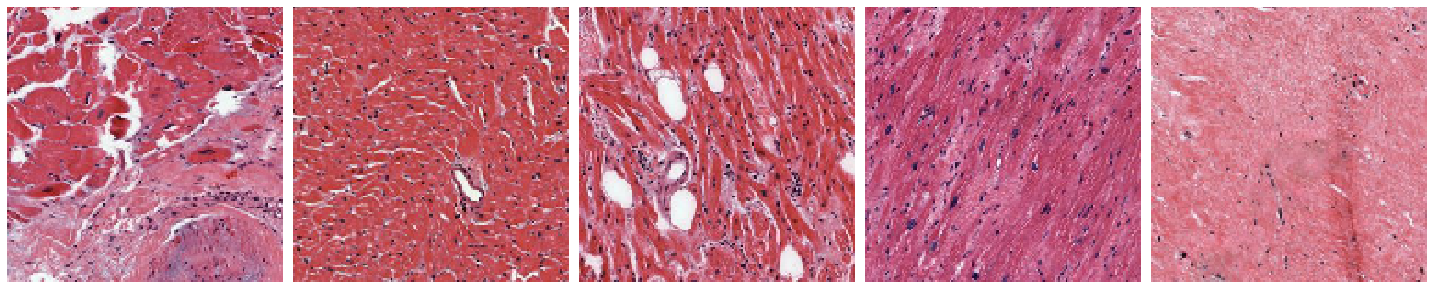

In [14]:
plotImages(sample_training_images[:5])

## Create the model

The model consists of three convolution blocks with a max pool layer in each of them. There's a fully connected layer with 512 units on top of it that is activated by a `relu` activation function.

In [15]:
model = Sequential([
#     Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
#     MaxPooling2D(),
#     Conv2D(32, 3, padding='same', activation='relu'),
#     MaxPooling2D(),
#     Conv2D(64, 3, padding='same', activation='relu'),
#     MaxPooling2D(),
#     Flatten(),
#     Dense(512, activation='relu'),
#     Dense(1)

    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(128, 3, padding='same', activation='relu'),
    Conv2D(256, 3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1)
])

### Compile the model

As all the other black magic in ML, the *ADAM* optimizer and *binary cross entropy* loss function are used here. To view training and validation accuracy for each training epoch, pass the `metrics` argument.

In [16]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Model summary

View all the layers of the network using the model's `summary` method:

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 37, 37, 128)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 37, 37, 256)       2

### Train the model

Use the `fit_generator` method of the `ImageDataGenerator` class to train the network.

In [18]:
history = model.fit(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 7 steps, validate for 7 steps
Epoch 1/100
7/7 [==============================] - 70s 10s/step - loss: 6.0322 - accuracy: 0.5264 - val_loss: 0.8468 - val_accuracy: 0.4665
Epoch 2/100
7/7 [==============================] - 47s 7s/step - loss: 0.6356 - accuracy: 0.6376 - val_loss: 1.7640 - val_accuracy: 0.5379
Epoch 3/100
7/7 [==============================] - 47s 7s/step - loss: 0.5506 - accuracy: 0.7030 - val_loss: 1.3420 - val_accuracy: 0.5379
Epoch 4/100
7/7 [==============================] - 47s 7s/step - loss: 0.5346 - accuracy: 0.7133 - val_loss: 1.2252 - val_accuracy: 0.5379
Epoch 5/100
7/7 [==============================] - 48s 7s/step - loss: 0.4651 - accuracy: 0.7366 - val_loss: 1.2740 - val_accuracy: 0.5379
Epoch 6/100
7/7 [==============================] - 47s 7s/step - loss: 0.4389 - accuracy: 0.7718 - val_loss: 1.1910 - val_accuracy: 0.5379
Epoch 7/100
7/7 [==============================] - 48s 7s/step - loss: 0.38

7/7 [==============================] - 47s 7s/step - loss: 1.9053e-04 - accuracy: 1.0000 - val_loss: 0.5191 - val_accuracy: 0.7935
Epoch 58/100
7/7 [==============================] - 48s 7s/step - loss: 1.9124e-04 - accuracy: 1.0000 - val_loss: 0.5305 - val_accuracy: 0.7891
Epoch 59/100
7/7 [==============================] - 47s 7s/step - loss: 1.7947e-04 - accuracy: 1.0000 - val_loss: 0.5179 - val_accuracy: 0.7980
Epoch 60/100
7/7 [==============================] - 48s 7s/step - loss: 1.7997e-04 - accuracy: 1.0000 - val_loss: 0.4966 - val_accuracy: 0.7969
Epoch 61/100
7/7 [==============================] - 48s 7s/step - loss: 1.6313e-04 - accuracy: 1.0000 - val_loss: 0.5399 - val_accuracy: 0.7935
Epoch 62/100
7/7 [==============================] - 48s 7s/step - loss: 1.6562e-04 - accuracy: 1.0000 - val_loss: 0.5117 - val_accuracy: 0.7935
Epoch 63/100
7/7 [==============================] - 48s 7s/step - loss: 1.5762e-04 - accuracy: 1.0000 - val_loss: 0.5266 - val_accuracy: 0.7980
Epoch

### Visualize training results

Now visualize the results after training the network.

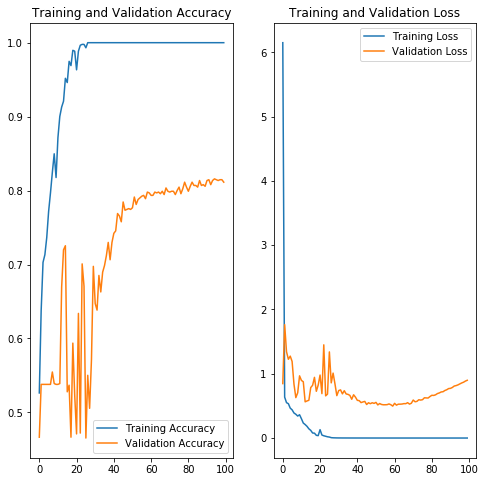

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The training accuracy and validation accuracy are off by large margin and the model has achieved only around **75%** accuracy on the validation set while the training set is well on its way to **85%**. If given more epochs, the accuracy will diverge further. So does the loss.

## Overfitting

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 75% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of *overfitting*.

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. The *data augmentation* and *dropout* are popular techniques to overcome that.

## Data augmentation

Overfitting generally occurs when there are a small number of training examples. One way to fix this problem is to augment the dataset so that it has a sufficient number of training examples. Data augmentation takes the approach of generating more training data from existing training examples by augmenting them with random transformations that yield believable-looking images. The goal is the model will never see the exact same picture twice during training. This helps expose the model to more aspects of the data and generalize better.

Implement this in `tf.keras` using the `ImageDataGenerator` class. Pass  different transformations to the dataset and it will take care of applying it during the training process.

### Augment and visualize data

Begin by applying random horizontal flip augmentation to the dataset and see how individual images look like after the transformation.

### Apply horizontal flip

Pass `horizontal_flip` as an argument to the `ImageDataGenerator` class and set it to `True` to apply this augmentation.

In [20]:
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

In [21]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

Found 1000 images belonging to 2 classes.


Take one sample image from the training examples and repeat it five times so that the augmentation is applied to the same image five times.

In [22]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]

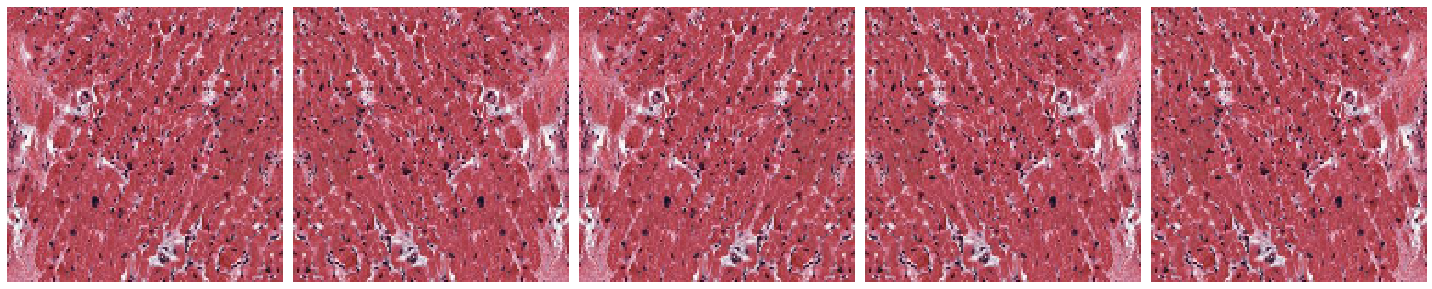

In [23]:
# Re-use the same custom plotting function defined and used
# above to visualize the training images
plotImages(augmented_images)

### Randomly rotate the image

Apply 45 degrees of rotation randomly to the training samples as another augmentation.

In [24]:
image_gen = ImageDataGenerator(rescale=1./255, rotation_range=45)

In [25]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

Found 1000 images belonging to 2 classes.


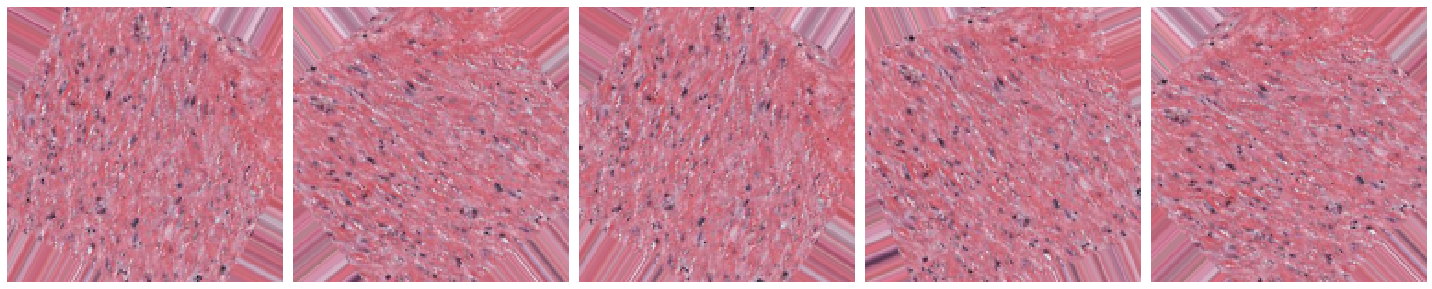

In [26]:
plotImages(augmented_images)

### Apply zoom augmentation

Apply a zoom augmentation to the dataset to zoom images up to 50% randomly.

In [27]:
# zoom_range from 0 - 1 where 1 = 100%.
image_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.5) # 

In [28]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

Found 1000 images belonging to 2 classes.


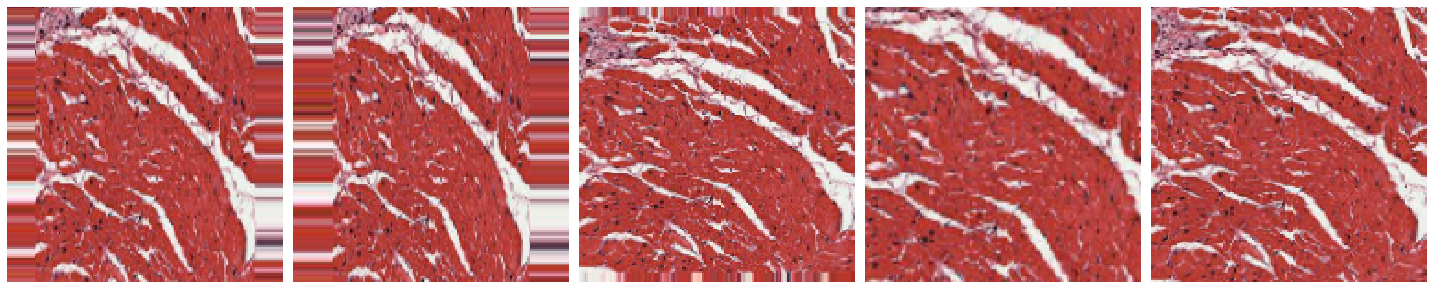

In [29]:
plotImages(augmented_images)

### Put it all together

Apply all the previous augmentations: rescale, 45 degree rotation, width shift, height shift, horizontal flip and zoom augmentation to the training images.

In [30]:
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )

In [31]:
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

Found 1000 images belonging to 2 classes.


Visualize how a single image would look five different times when passing these augmentations randomly to the dataset.

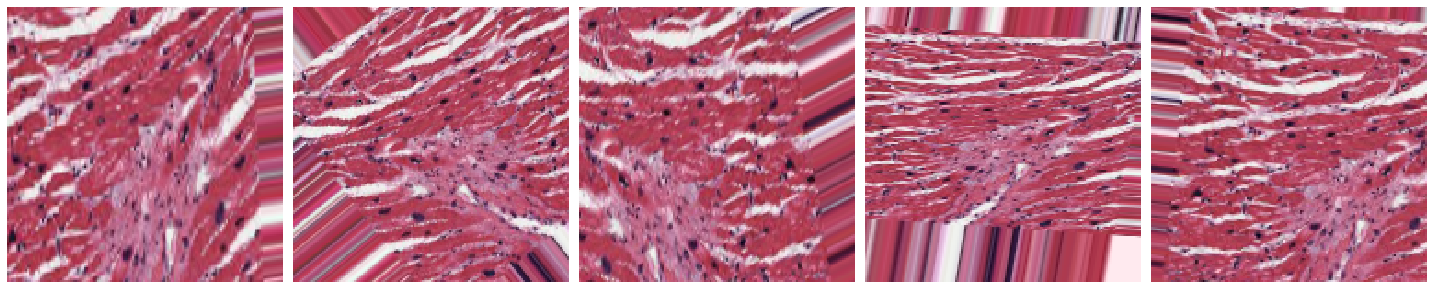

In [32]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Create validation data generator

Generally, only apply data augmentation to the training examples. In this case, only rescale the validation images and convert them into batches using `ImageDataGenerator`.

In [33]:
image_gen_val = ImageDataGenerator(rescale=1./255)

In [34]:
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=validation_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='binary')

Found 978 images belonging to 2 classes.


## Dropout

Another technique to reduce overfitting is to introduce *dropout* to the network. It is a form of *regularization* that forces the weights in the network to take only small values, which makes the distribution of weight values more regular and the network can reduce overfitting on small training examples. Dropout is one of the regularization technique used in multiple ML scenarios, including image classification.

When you apply dropout to a layer it randomly drops out (set to zero) number of output units from the applied layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

When appling 0.1 dropout to a certain layer, it randomly kills 10% of the output units in each training epoch.

Create a network architecture with this new dropout feature and apply it to different convolutions and fully-connected layers.

## Creating a new network with Dropouts

Apply dropout to first and last max pool layers. Applying dropout will randomly set 20% of the neurons to zero during each training epoch. This helps to avoid overfitting on the training dataset. And of course, it could also forget useful knowledge.

In [35]:
model_new = Sequential([
#     Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
#     MaxPooling2D(),
#     Dropout(0.2),
#     Conv2D(32, 3, padding='same', activation='relu'),
#     MaxPooling2D(),
#     Conv2D(64, 3, padding='same', activation='relu'),
#     MaxPooling2D(),
#     Conv2D(128, 3, padding='same', activation='relu'),
#     MaxPooling2D(),
#     Dropout(0.2),
#     Flatten(),
#     Dense(512, activation='relu'),
#     Dense(1)
    
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(128, 3, padding='same', activation='relu'),
    Conv2D(256, 3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1)
])

### Compile the model

After introducing dropouts to the network, compile the model and view the layers summary.

In [36]:
model_new.compile(optimizer='adam',
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy'])

model_new.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 37, 37, 128)       73856     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 37, 37, 256)      

### Train the model

After successfully introducing data augmentations to the training examples and adding dropouts to the network, train this new network:

In [37]:
history = model_new.fit(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 7 steps, validate for 7 steps
Epoch 1/100
7/7 [==============================] - 50s 7s/step - loss: 6.0718 - accuracy: 0.4862 - val_loss: 0.7077 - val_accuracy: 0.5301
Epoch 2/100
7/7 [==============================] - 49s 7s/step - loss: 0.6786 - accuracy: 0.5126 - val_loss: 0.6941 - val_accuracy: 0.5301
Epoch 3/100
7/7 [==============================] - 49s 7s/step - loss: 0.6614 - accuracy: 0.5161 - val_loss: 0.6928 - val_accuracy: 0.5301
Epoch 4/100
7/7 [==============================] - 48s 7s/step - loss: 0.6195 - accuracy: 0.5952 - val_loss: 0.6931 - val_accuracy: 0.5301
Epoch 5/100
7/7 [==============================] - 49s 7s/step - loss: 0.5585 - accuracy: 0.7053 - val_loss: 0.7256 - val_accuracy: 0.5301
Epoch 6/100
7/7 [==============================] - 49s 7s/step - loss: 0.5645 - accuracy: 0.7087 - val_loss: 0.6845 - val_accuracy: 0.5301
Epoch 7/100
7/7 [==============================] - 49s 7s/step - loss: 0.508

7/7 [==============================] - 49s 7s/step - loss: 0.3510 - accuracy: 0.8326 - val_loss: 0.4875 - val_accuracy: 0.6808
Epoch 59/100
7/7 [==============================] - 49s 7s/step - loss: 0.3693 - accuracy: 0.8360 - val_loss: 0.7242 - val_accuracy: 0.5379
Epoch 60/100
7/7 [==============================] - 49s 7s/step - loss: 0.3296 - accuracy: 0.8452 - val_loss: 0.5672 - val_accuracy: 0.5815
Epoch 61/100
7/7 [==============================] - 49s 7s/step - loss: 0.3146 - accuracy: 0.8624 - val_loss: 1.4030 - val_accuracy: 0.5357
Epoch 62/100
7/7 [==============================] - 50s 7s/step - loss: 0.3037 - accuracy: 0.8650 - val_loss: 1.0072 - val_accuracy: 0.5346
Epoch 63/100
7/7 [==============================] - 49s 7s/step - loss: 0.2704 - accuracy: 0.8807 - val_loss: 0.9732 - val_accuracy: 0.5469
Epoch 64/100
7/7 [==============================] - 49s 7s/step - loss: 0.2651 - accuracy: 0.8876 - val_loss: 1.3043 - val_accuracy: 0.5045
Epoch 65/100
7/7 [===============

### Visualize the model

Visualize the new model after training. There is significantly less overfitting than before. The accuracy suffers slightly. However, there is no divergence in either accuracy or loss in training and verification data sets.

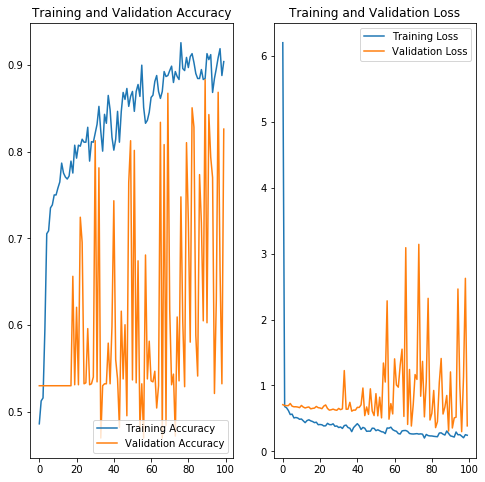

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()